In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN

%matplotlib inline

In [14]:
# Load the dataset
df = pd.read_csv("synthetic_melanoma_with_nolabels.csv")

# Preview shape and data types
print("Shape of the dataset:", df.shape)
print("\nData types summary:")
print(df.dtypes.value_counts())

# Show first few rows
df.head()


Shape of the dataset: (100, 500)

Data types summary:
float64    500
Name: count, dtype: int64


,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_491,gene_492,gene_493,gene_494,gene_495,gene_496,gene_497,gene_498,gene_499,gene_500
0,-8.036858,-3.367611,3.824087,3.387582,NaN,7.051599,3.638453,9.282094,NaN,-0.195458,...,-2.726041,-5.342292,-7.123032,-7.960058,3.013350,0.744939,7.045499,-5.423776,-2.268775,7.756442
1,2.433979,2.959668,-2.977225,8.948763,6.476470,-11.065810,11.595469,8.827897,8.072936,NaN,...,4.536989,-1.076723,-5.360812,NaN,-0.078107,-7.197361,3.280848,NaN,13.923886,NaN
2,NaN,0.444426,NaN,NaN,4.465978,3.054978,0.286623,8.269176,-4.355281,-3.366072,...,NaN,-2.481276,-1.710349,-8.240348,0.880221,3.143318,2.783903,-7.841752,-1.176521,10.663934
3,4.417235,-0.721212,-2.612097,8.703946,1.175441,-7.248796,7.601835,7.581463,NaN,3.135705,...,NaN,4.494957,-6.622522,NaN,-6.183917,-10.948802,NaN,-5.546025,11.173246,2.951092
4,-3.532067,-1.561022,4.472985,2.654212,NaN,4.064745,5.816656,NaN,NaN,0.362479,...,-4.064570,-3.670654,NaN,-4.233416,3.248945,5.743606,-0.169827,NaN,-2.757820,4.050272


In [16]:
# Five point summary

five_number_summary = df.describe().T[['min', '25%', '50%', '75%', 'max']]
five_number_summary.head()

,min,25%,50%,75%,max
gene_1,-11.042895,-4.814654,-0.956864,2.836686,8.330709
gene_2,-5.126491,0.097395,2.571247,7.324303,13.935921
gene_3,-8.604029,-0.911371,4.011542,6.225186,12.257412
gene_4,-4.795690,2.107831,4.035975,5.850952,11.713994
gene_5,-13.071607,-5.031346,1.348316,5.761125,11.100775


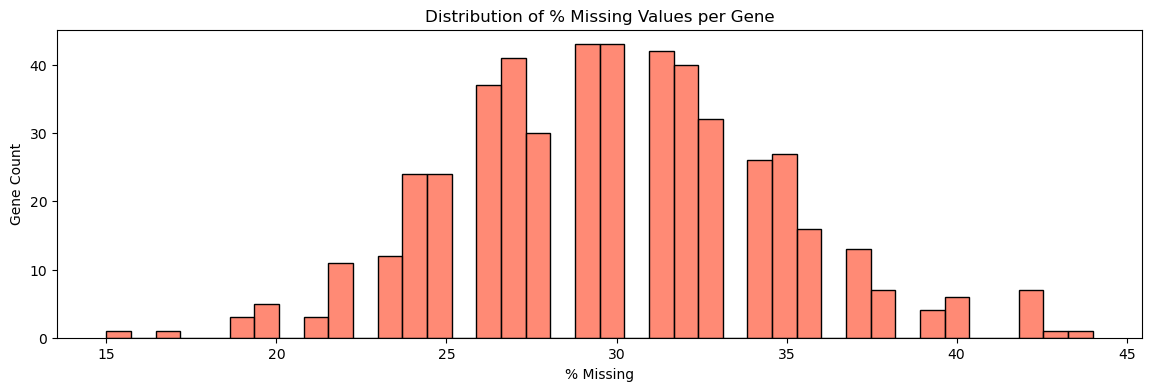

In [20]:
# Missing Data Analysis
#---------------------------------------------------------------
# Check and visualize missing data
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(14, 4))
sns.histplot(missing_percent, bins=40, color='tomato')
plt.title("Distribution of % Missing Values per Gene")
plt.xlabel("% Missing")
plt.ylabel("Gene Count")
plt.show()

 Handling Missing Values
-----------------------------------------------------------

In [23]:

# Display missing percentages
missing_summary = (df.isnull().sum() / len(df)) * 100
missing_summary = missing_summary.sort_values(ascending=False)
print("Columns with missing values (sorted):")
display(missing_summary.to_frame(name='% Missing'))

# Drop columns with missing > threshold (customizable)
threshold = 40  # you can adjust this value
columns_to_drop = missing_summary[missing_summary > threshold].index
print(f"\nColumns to drop (>{threshold}% missing):")
print(list(columns_to_drop))

df_cleaned = df.drop(columns=columns_to_drop)
print(f"\nNew shape of dataset: {df_cleaned.shape}")

Columns with missing values (sorted):


,% Missing
gene_69,44.0
gene_443,43.0
gene_264,42.0
gene_79,42.0
gene_284,42.0
...,...
gene_168,19.0
gene_450,19.0
gene_171,19.0
gene_53,17.0



Columns to drop (>40% missing):
['gene_69', 'gene_443', 'gene_264', 'gene_79', 'gene_284', 'gene_459', 'gene_108', 'gene_102', 'gene_216']

New shape of dataset: (100, 491)


In [27]:
#Impute missing values with column mean
# Impute the remaining values

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned), columns=df_cleaned.columns)
print("\nMissing values after imputation:", df_imputed.isnull().sum().sum())


Missing values after imputation: 0


In [35]:
# Feature Standardization
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

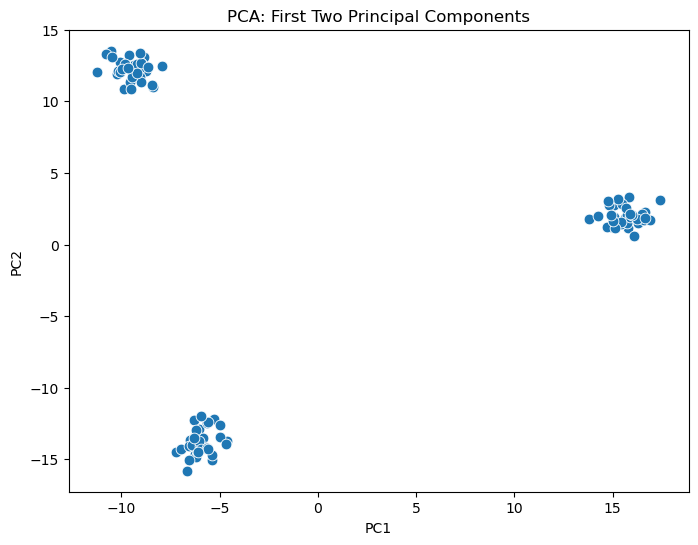

In [37]:
# Principal Component Analysis (PCA) for Dimensionality Reduction

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=60)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: First Two Principal Components")
plt.show()

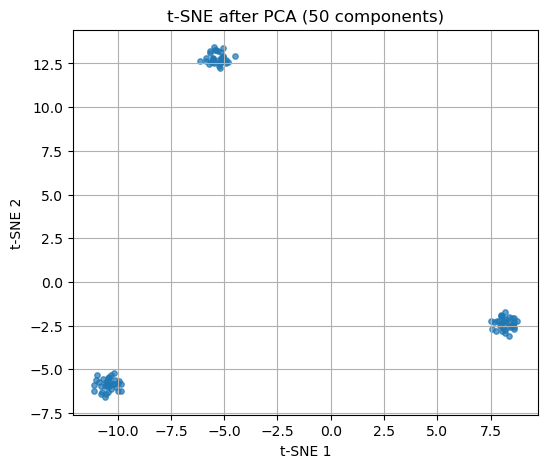

In [41]:
# t-SNE Visualization

# Step 1: PCA to 50 components (using df_scaled)
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(df_scaled)

# Step 2: t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca_50)

# Step 3: Plot
plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=15, alpha=0.7)
plt.title('t-SNE after PCA (50 components)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

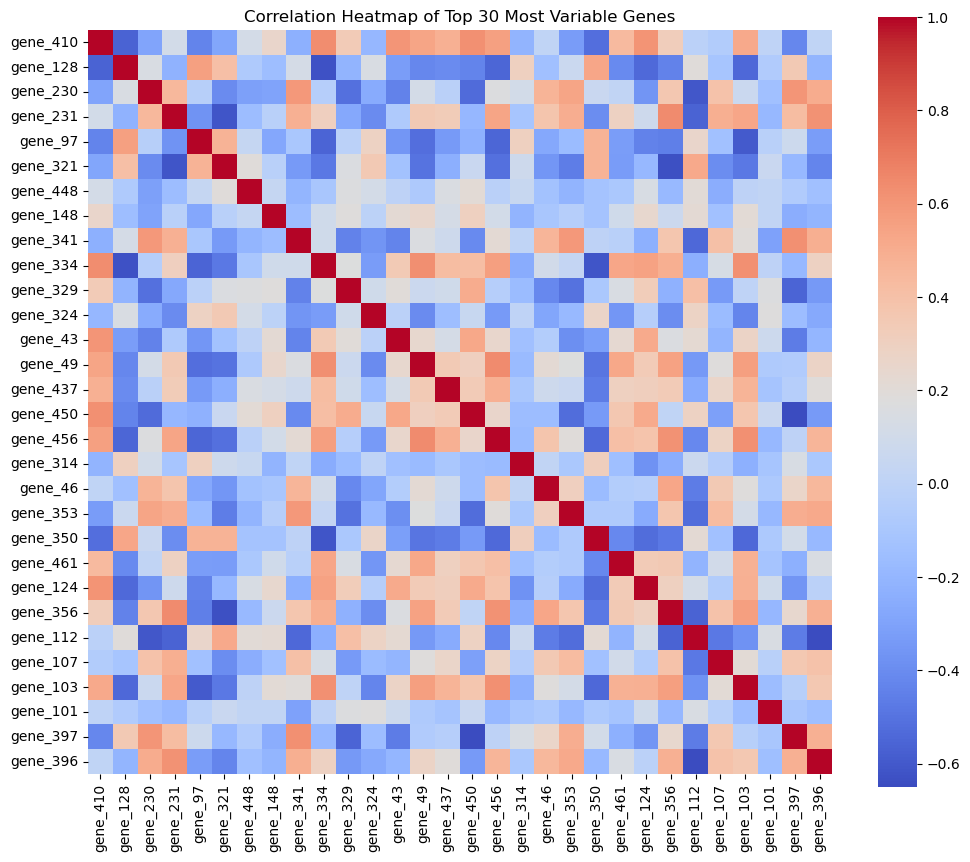

In [43]:
# Correlation Heatmap of Top Genes

top_var_genes = df_scaled.var().sort_values(ascending=False).head(30).index
corr_matrix = df_scaled[top_var_genes].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Top 30 Most Variable Genes")
plt.show()

C:\Users\kwesi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kwesi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kwesi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kwesi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

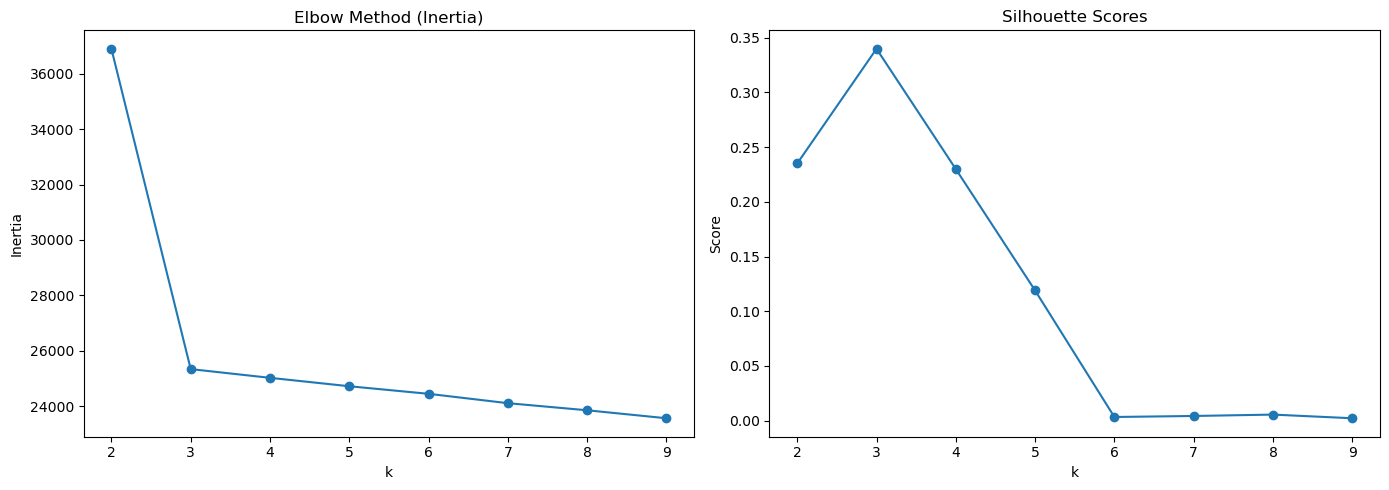

In [47]:
# Determine Optimal Number of Clusters
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

# Plot Elbow and Silhouette Score
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(k_range, inertia, marker='o')
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(k_range, silhouette_scores, marker='o')
ax[1].set_title("Silhouette Scores")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score")
plt.tight_layout()
plt.show()

C:\Users\kwesi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


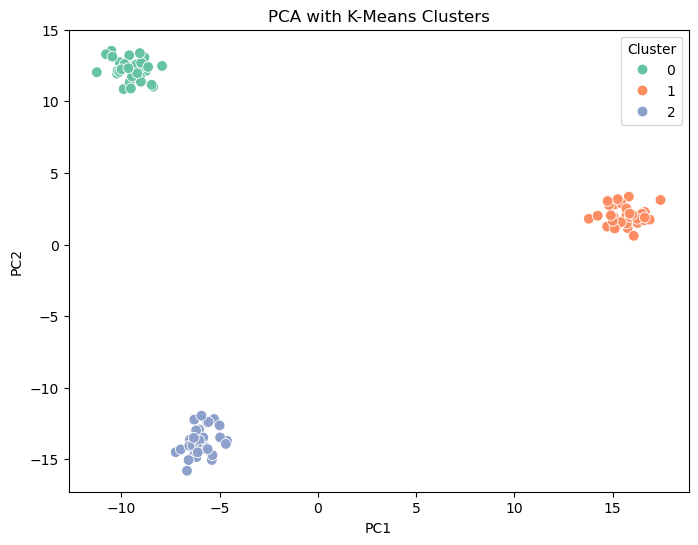

In [49]:
# K-Means Clustering and Visualization

# From previous step assume best_k=3 (or choose based on silhouette)
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_scaled['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

# PCA visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_scaled['KMeans_Cluster'], palette='Set2', s=60)
plt.title("PCA with K-Means Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

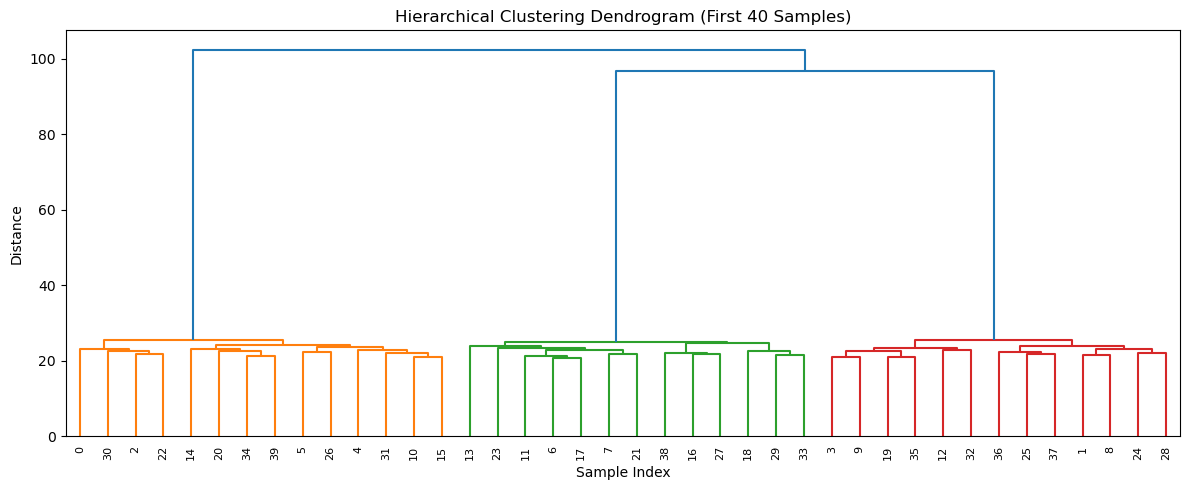

In [53]:
# Hierarchical Clustering

# Use a subset to avoid overcrowding
sampled_data = df_scaled.iloc[:40, :-1]
linkage_matrix = linkage(sampled_data, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix, labels=sampled_data.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (First 40 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

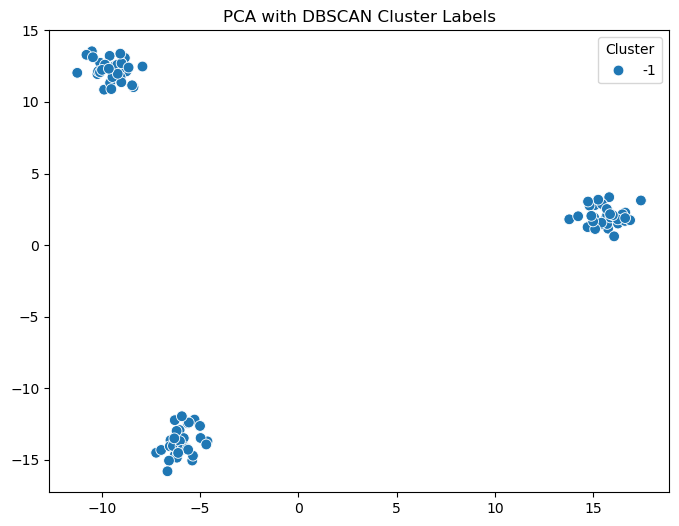

In [55]:
# DBSCAN Clustering

db = DBSCAN(eps=5, min_samples=5)
df_scaled['DBSCAN_Cluster'] = db.fit_predict(df_scaled.iloc[:, :-2])

# PCA with DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_scaled['DBSCAN_Cluster'], palette='tab10', s=60)
plt.title("PCA with DBSCAN Cluster Labels")
#plt.xlabel("PC1")
#plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()